In [5]:
import sys
sys.path.insert(0, '..')
from mne_bids import (BIDSPath,read_raw_bids)
import mne_bids
import importlib
import mne
import ccs_eeg_utils

#ccs_eeg_utils.download_erpcore(task="P3",subject=30,localpath="../local/bids/")

bids_root = "../local/bids"
bids_root = "/bigpool/export/users/ehinger/erp-core/bids" # Bene's Server location
subject_id = '030'


bids_path = BIDSPath(subject=subject_id,task="P3",
                     datatype='eeg', suffix='eeg',session="P3",
                     root=bids_root)

raw = read_raw_bids(bids_path)
ccs_eeg_utils.read_annotations_core(bids_path,raw)
raw.load_data()
raw.filter(0.5,50, fir_design='firwin')

<ipython-input-5-652495d8e2fe>:20: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = read_raw_bids(bids_path)


Reading events from /bigpool/export/users/ehinger/erp-core/bids/sub-030/ses-P3/eeg/sub-030_ses-P3_task-P3_events.tsv.
The event "response" refers to multiple event values. Creating hierarchical event names.
    Renaming event: response -> response/202
    Renaming event: response -> response/202
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response -> response/201
    Renaming event: response

<ipython-input-5-652495d8e2fe>:20: RuntimeWarning: Participants file not found for sub-030_ses-P3_task-P3_eeg.set... Not reading in any particpants.tsv data.
  raw = read_raw_bids(bids_path)


<RawEEGLAB | sub-030_ses-P3_task-P3_eeg.set, 33 x 393216 (384.0 s), ~99.0 MB, data loaded>

**T:** Go through the dataset using the MNE explorer and clean it. You can use `raw.plot()` for this. If you are working from a jupyter notebook, try to use `%matplotlib qt` for better support of the cleaning window. To get an understanding how the tool works, press `help` or type `?` in the window. (Hint: You first have to add a new annotation by pressing `a`)

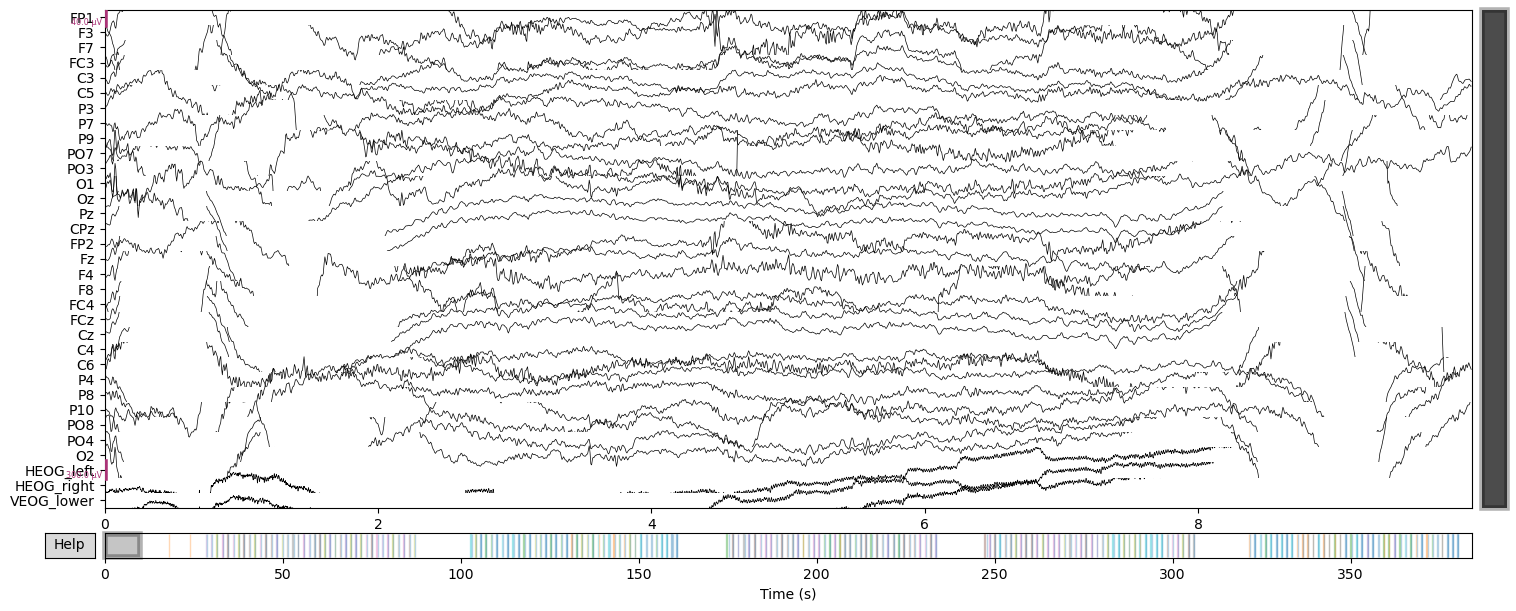

In [6]:
%matplotlib qt
raw.plot(n_channels=len(raw.ch_names))#,scalings =40e-6)
# See below

In [7]:
bad_ix = [i for i,a in enumerate(raw.annotations) if a['description']=="BAD_"]

#raw.annotations[bad_ix].save("sub-{}_task-P3_badannotations.csv".format(subject_id))


annotations = mne.read_annotations("sub-{}_task-P3_badannotations.csv".format(subject_id))
raw.annotations.append(annotations.onset,annotations.duration,annotations.description)


FileNotFoundError: fname does not exist: sub-030_task-P3_badannotations.csv

Channels marked as bad: none


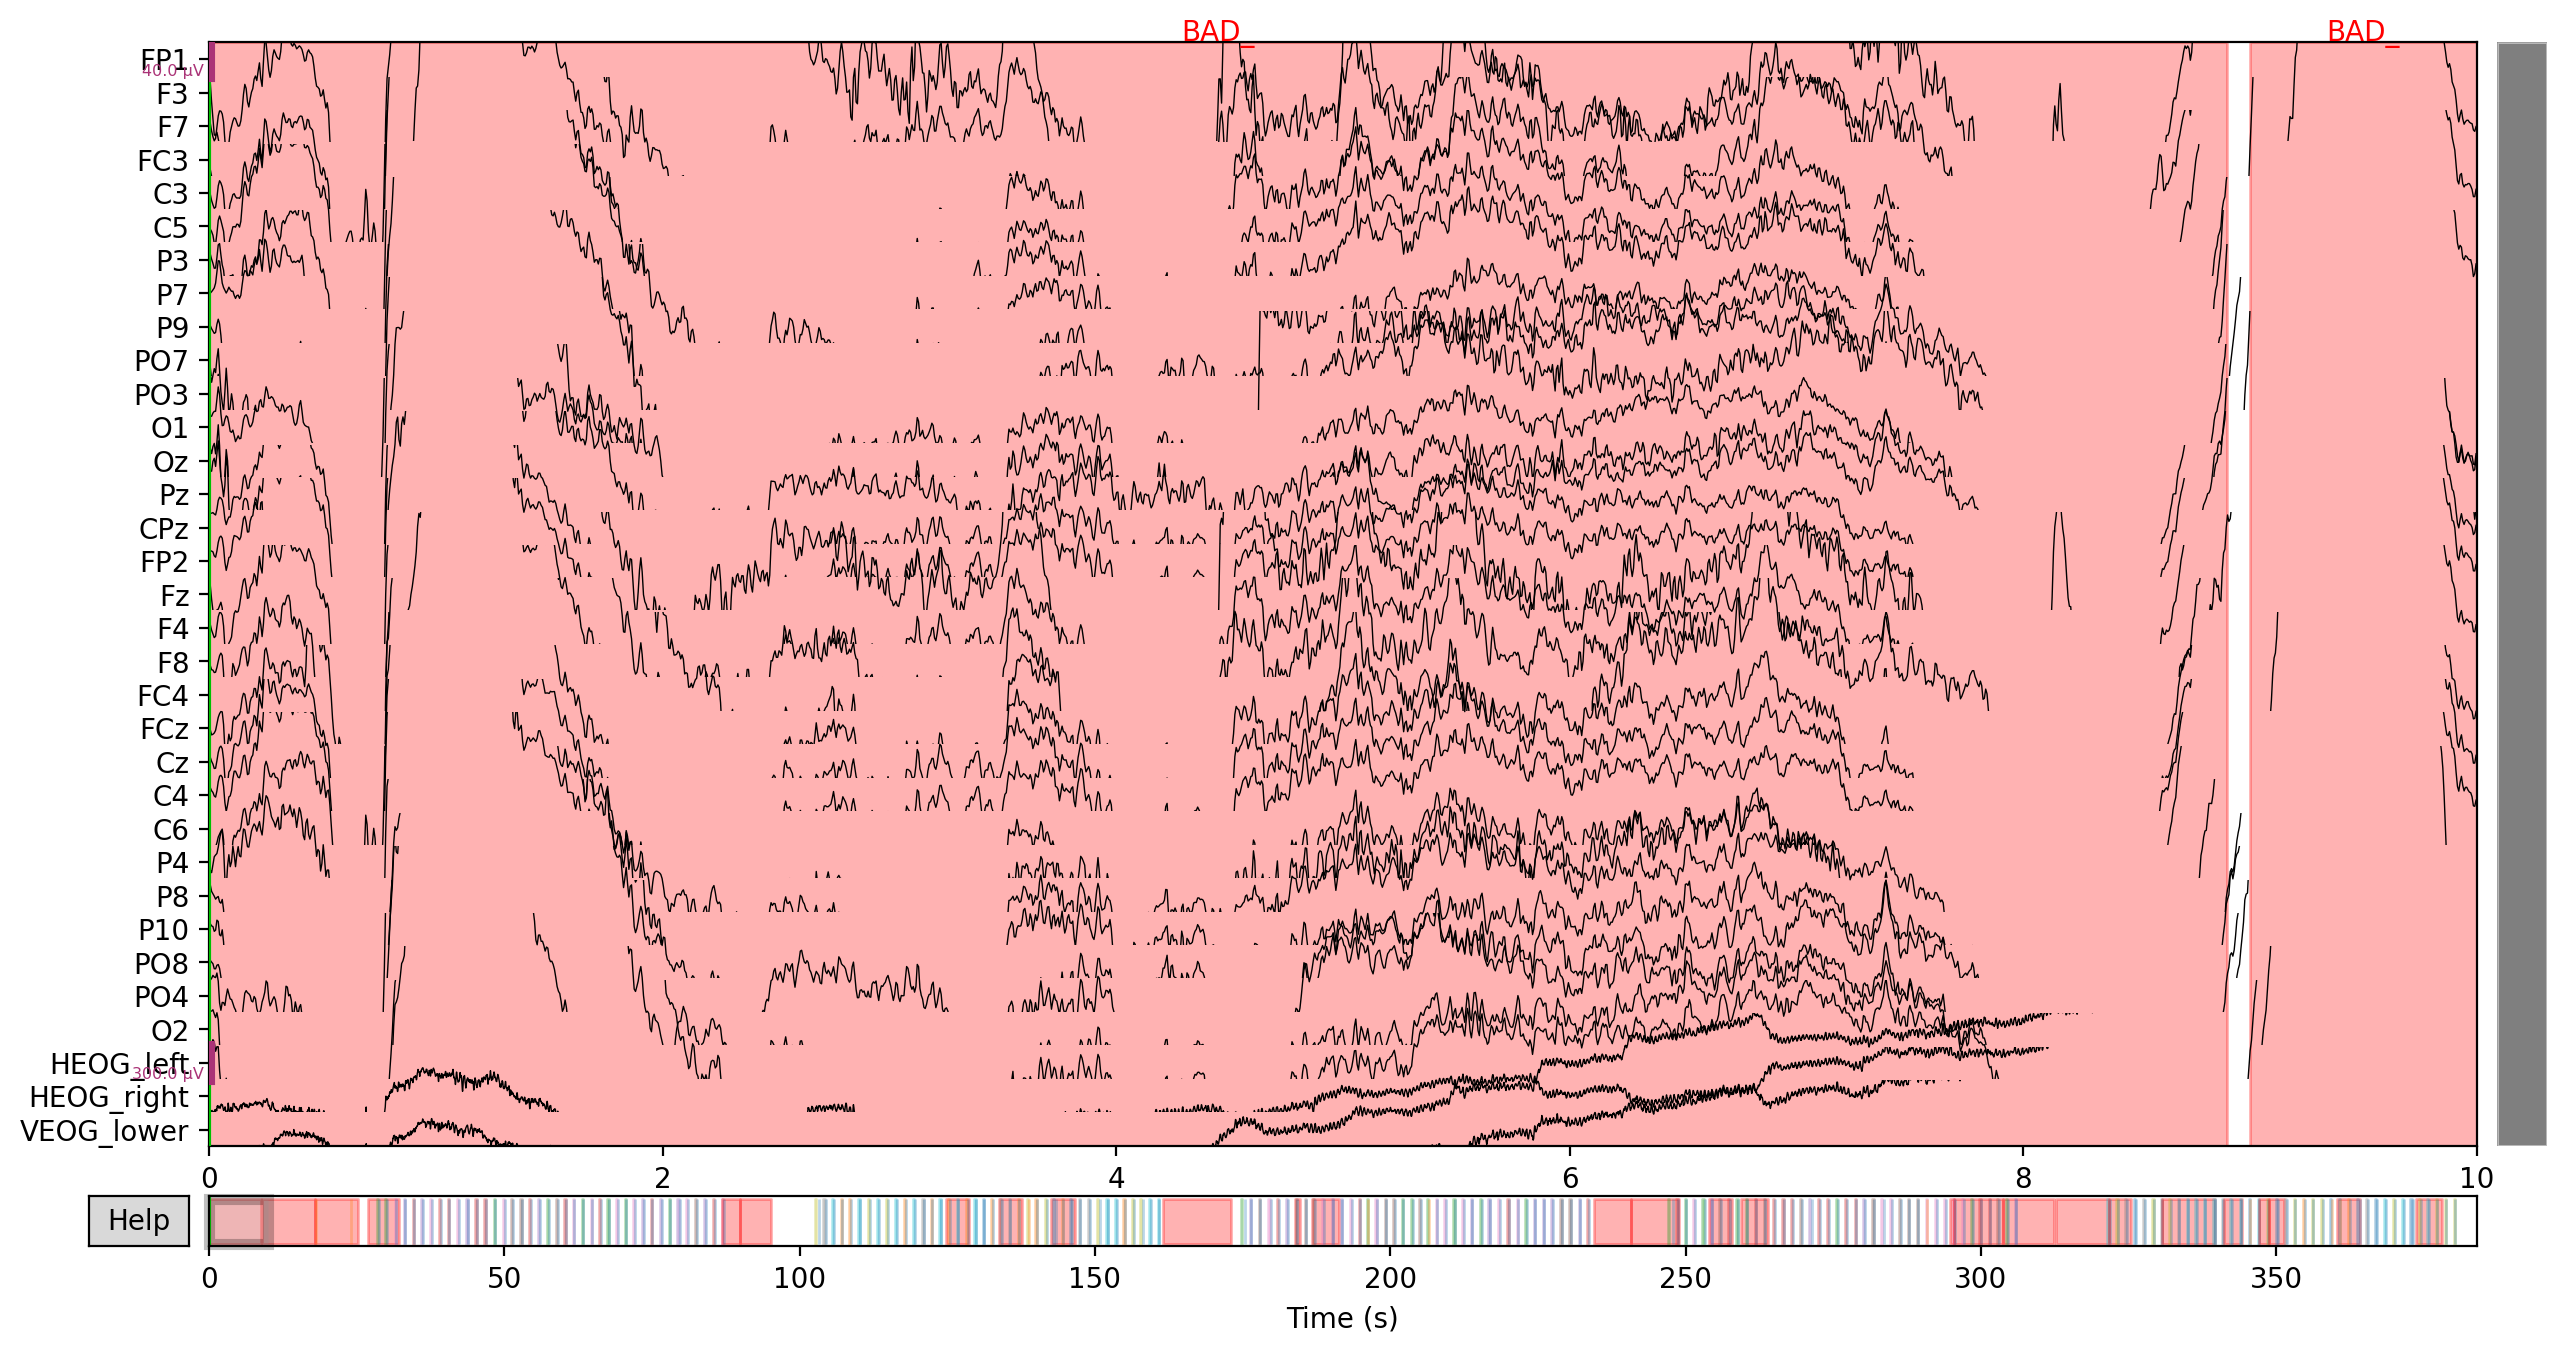

In [ ]:
%matplotlib qt
raw.plot(n_channels=len(raw.ch_names))


**T:** While going through the dataset, mark what you observe as bad electrodes. Those are saved in `raw.info['bads']`. The channels can be interpolated with `raw.interpolate_bads()` or `epoch.interpolate_bads()`. Compare the channel + neighbours before and after. Did the interpolation succeed? (If you are interested in the mathematical details of spline interpolation, checkout this https://mne.tools/dev/overview/implementation.html#id26)
Hint: You need channel locations to run the interpolation which you can get by using the default-standardized channel locations `raw.set_montage('standard_1020',match_case=False)`

In [ ]:
# I thought there was not really a bad channel in this dataset, so I remove one at random.
raw.info['bads'] = ['FP2']
# for interpolation
raw.set_montage('standard_1020',match_case=False)
raw.interpolate_bads()

Interpolating bad channels
    Automatic origin fit: head of radius 93.5 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors


<RawEEGLAB | sub-030_task-P3_eeg.fdt, 33 x 393216 (384.0 s), ~99.1 MB, data loaded>

**T:** In the epoching step, we can also specify rejection criterion for a peak-to-peak rejection method

Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
Not setting metadata
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz',

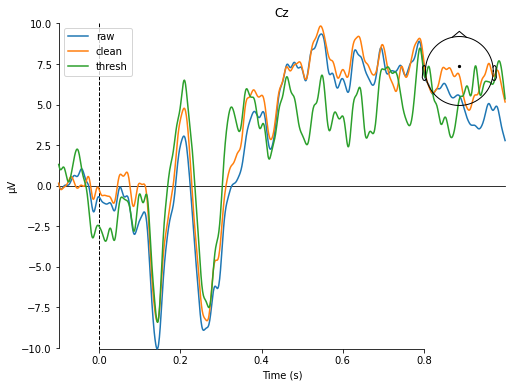

[<Figure size 576x432 with 2 Axes>]

In [ ]:
%matplotlib inline
import mne
evts,evts_dict = mne.events_from_annotations(raw)
wanted_keys = [e for e in evts_dict.keys() if "stimulus" in e]
evts_dict_stim=dict((k, evts_dict[k]) for k in wanted_keys if k in evts_dict)

# get epochs with and without rejection
epochs        = mne.Epochs(raw,evts,evts_dict_stim,tmin=-0.1,tmax=1,reject_by_annotation=False)
epochs_manual = mne.Epochs(raw,evts,evts_dict_stim,tmin=-0.1,tmax=1,reject_by_annotation=True)
reject_criteria = dict(eeg=200e-6,       # 100 µV # HAD TO INCREASE IT HERE, 100 was too harsh
                       eog=200e-6)       # 200 µV
epochs_thresh = mne.Epochs(raw,evts,evts_dict_stim,tmin=-0.1,tmax=1,reject=reject_criteria,reject_by_annotation=False)

#from matplotlib import pyplot as plt
# compare
#plt.plot([0,:])
mne.viz.plot_compare_evokeds({'raw':epochs.average(),'clean':epochs_manual.average(),'thresh':epochs_thresh.average()},picks="Cz")


## Bonus Tasks!

In [ ]:
from autoreject import AutoReject
ar = AutoReject(verbose='tqdm')
epochs.load_data()
epochs_ar = ar.fit_transform(epochs)  

Computing thresholds ...: 100%|██████████| 30/30 [02:14<00:00,  4.47s/it]


Repairing epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Repairing epochs:   8%|▊         | 16/200 [00:00<00:01, 147.19it/s]

Repairing epochs:  14%|█▍        | 29/200 [00:00<00:01, 136.79it/s]

Repairing epochs:  20%|█▉        | 39/200 [00:00<00:01, 121.52it/s]

Repairing epochs:  24%|██▎       | 47/200 [00:00<00:01, 102.60it/s]

Repairing epochs:  28%|██▊       | 55/200 [00:00<00:01, 92.40it/s] 

Repairing epochs:  34%|███▎      | 67/200 [00:00<00:01, 97.86it/s]

Repairing epochs:  38%|███▊      | 77/200 [00:00<00:01, 97.99it/s]

Repairing epochs:  46%|████▌     | 91/200 [00:00<00:01, 105.04it/s]

Repairing epochs:  51%|█████     | 102/200 [00:00<00:00, 101.14it/s]

Repairing epochs:  56%|█████▌    | 112/200 [00:01<00:01, 64.11it/s] 

Repairing epochs:  60%|██████    | 120/200 [00:01<00:01, 66.35it/s]

Repairing epochs:  64%|██████▍   | 128/200 [00:01<00:01, 66.83it/s]

Repairing epochs:  68%|██████▊   | 13

In [ ]:
r = ar.get_reject_log(epochs)

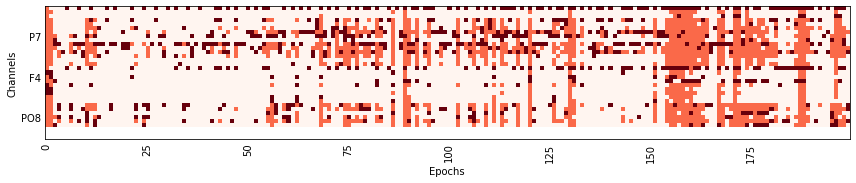

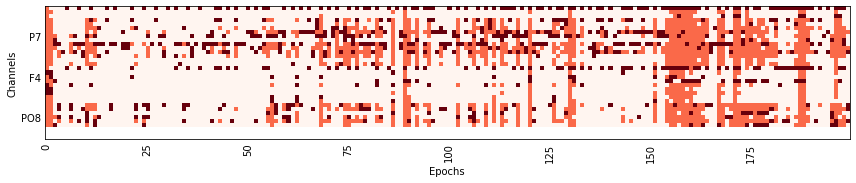

In [ ]:
r.plot(orientation="horizontal")

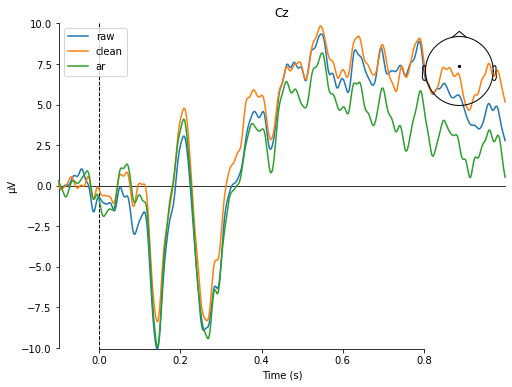

[<Figure size 576x432 with 2 Axes>]

In [ ]:

mne.viz.plot_compare_evokeds({
    'raw':epochs.average(),
    'clean':epochs_manual.average(),
    'ar':epochs_ar.average()
    },picks="Cz")


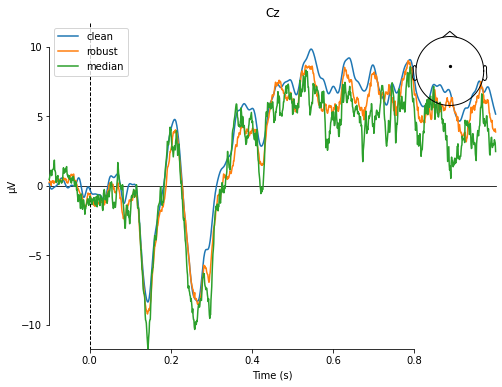

[<Figure size 576x432 with 2 Axes>]

In [ ]:
from scipy.stats.mstats import winsorize
import numpy as np
def winsor(d):
    return np.mean(winsorize(d,axis=0,limits=(0.2,0.2)),axis=0)
def median(d):
    return np.median(d,axis=0)

mne.viz.plot_compare_evokeds({
    'clean':epochs_manual.average(),
    'robust':epochs.average(method=winsor),
    'median':epochs.average(method=median),
    },picks="Cz")

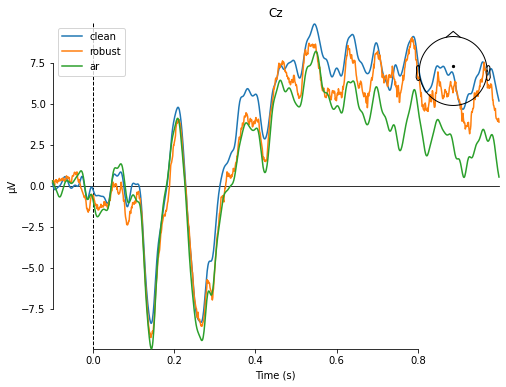

[<Figure size 576x432 with 2 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds({
    'clean':epochs_manual.average(),
    'robust':epochs.average(method=winsor),
    'ar':epochs_ar.average()
    },picks="Cz")

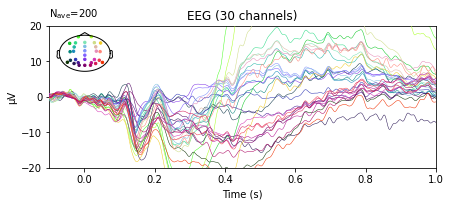

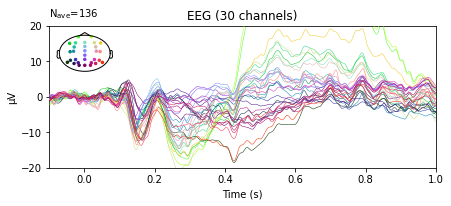

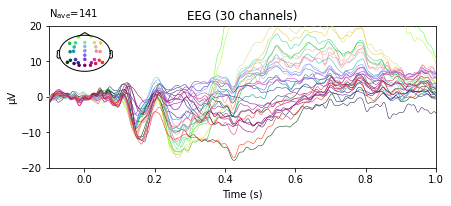

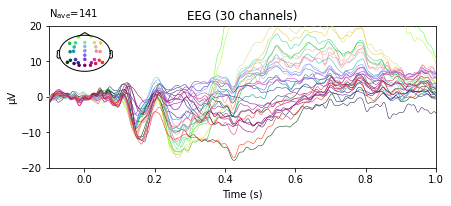

In [ ]:
%matplotlib inline
ylim = dict(eeg=(-20, 20))
epochs.average().plot(ylim=ylim, spatial_colors=True);
epochs_ar.average().plot(ylim=ylim, spatial_colors=True);
epochs_manual.average().plot(ylim=ylim, spatial_colors=True);